## 1. 모듈 및 데이터셋 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# %cd /content/drive/MyDrive/기업연계프로젝트/연습/crack_segmentation_dataset

# !unzip  "/content/drive/MyDrive/기업연계프로젝트/연습/crack_segmentation_dataset.zip"

In [3]:
import os 
import cv2
import torch
import torchvision

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from glob import glob
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
# from save import save_model

In [4]:
data_dir = "/content/drive/MyDrive/기업연계프로젝트/연습/crack_segmentation_dataset/"
images_path = data_dir+"images/"
masks_path = data_dir+"masks/"

images_paths = glob(images_path + '*.jpg')
masks_paths = glob(masks_path + '*.jpg')

images_paths = sorted([str(p) for p in images_paths])
masks_paths = sorted([str(p) for p in masks_paths])

df = pd.DataFrame({'images': images_paths, 'masks': masks_paths})

df.head(5)

,images,masks
0,/content/drive/MyDrive/기업연계프로젝트/연...,/content/drive/MyDrive/기업연계프로젝트/연...
1,/content/drive/MyDrive/기업연계프로젝트/연...,/content/drive/MyDrive/기업연계프로젝트/연...
2,/content/drive/MyDrive/기업연계프로젝트/연...,/content/drive/MyDrive/기업연계프로젝트/연...
3,/content/drive/MyDrive/기업연계프로젝트/연...,/content/drive/MyDrive/기업연계프로젝트/연...
4,/content/drive/MyDrive/기업연계프로젝트/연...,/content/drive/MyDrive/기업연계프로젝트/연...


In [5]:
df.iloc[0].images

'/content/drive/MyDrive/기업연계프로젝트/연습/crack_segmentation_dataset/images/crack_0.jpg'

In [6]:
train, test = train_test_split(df, test_size=200, shuffle=True, random_state=42)
train, valid = train_test_split(train, test_size=0.1, shuffle=True, random_state=42)

print(f'Train size: {len(train)}, validation size: {len(valid)} and test size: {len(test)}')

Train size: 2253, validation size: 251 and test size: 200


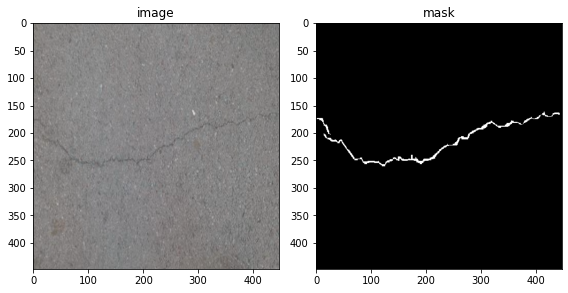

In [7]:
sub_index = 2

img_path = df.iloc[sub_index].images
mask_path = df.iloc[sub_index].masks

image = cv2.imread(img_path)
mask = cv2.imread(mask_path)

#.jpg이므로 0 또는 255로 나타내준다.
thres = 240
mask[mask < thres] = 0
mask[mask >= thres] = 255

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title("image")
plt.imshow(image)
plt.subplot(122)
plt.title("mask")
plt.imshow(mask)
plt.tight_layout()

## 2. 데이터셋 구축

In [8]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

BATCH_SIZE = 12
IMAGE_SIZE = 256
NUM_CLASSES = 1
EPOCHS = 30
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# ToPILImage: augmentation을 해주기 위해서는 먼저 PIL이미지로 변환
# ColorJitter: 밝기, 채도, 색조 변경
# RandomRotation(20): -20~20도 사이로 회전
# RandomHorizontalFlip: 좌우반전
# RandomVerticalFlip: 상하반전
transformer = T.Compose([
    T.ToPILImage(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # T.RandomRotation(20),
    # T.RandomHorizontalFlip(),
    # T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
class CrackDataset(Dataset):
    def __init__(self, dataset, transformer=transformer):
        self.dataset = dataset.reset_index(drop=True)
        self.transformer = transformer
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        row = self.dataset.loc[index].squeeze()
        image_path = row['images']
        mask_path = row['masks']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        image = self.transformer(image).float()

        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, dsize=(IMAGE_SIZE,IMAGE_SIZE), interpolation=cv2.INTER_NEAREST) # 새로운 값을 들어가지 않게 INTER_NEAREST로 처리
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255
        # _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        target = torch.as_tensor(mask[None], dtype=torch.float32)
        return image, target

    def collate_fn(self, batch):
        images, masks = tuple(zip(*batch))
        images = [img[None] for img in images]
        masks = [msk[None] for msk in masks]
        images, masks = [torch.cat(i).to(DEVICE) for i in [images, masks]]
        return images, masks
        

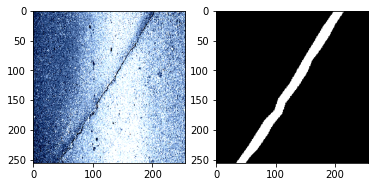

In [11]:
ds = CrackDataset(train)
plt.subplot(121)
plt.imshow(ds[1111][0].cpu().detach().numpy().transpose(1,2,0))
plt.subplot(122)
plt.imshow(np.squeeze(ds[1111][1]).cpu().detach().numpy(), cmap='gray')

In [12]:
train_dataset = CrackDataset(train)
valid_dataset = CrackDataset(valid)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)

## 3. U-Net 데이터 아키텍처 구현

In [13]:
def ConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    return layers

In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvLayer(in_channels=3, out_channels=64)
        self.conv_block2 = ConvLayer(in_channels=64, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128, out_channels=256)
        self.conv_block4 = ConvLayer(in_channels=256, out_channels=512)
        self.conv_block5 = ConvLayer(in_channels=512, out_channels=1024)
        self.pool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        encode_features = []
        out = self.conv_block1(x)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block2(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block3(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block4(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block5(out)
        return out, encode_features

In [15]:
def UpConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return layers

In [16]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv_layer1 = UpConvLayer(in_channels=1024, out_channels=512)
        self.conv_block1 = ConvLayer(in_channels=512+512, out_channels=512)
        
        self.upconv_layer2 = UpConvLayer(in_channels=512, out_channels=256)
        self.conv_block2 = ConvLayer(in_channels=256+256, out_channels=256)
        
        self.upconv_layer3 = UpConvLayer(in_channels=256, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128+128, out_channels=128)
        
        self.upconv_layer4 = UpConvLayer(in_channels=128, out_channels=64)
        self.conv_block4 = ConvLayer(in_channels=64+64, out_channels=64)
        
    def forward(self, x, encoder_features):
        out = self.upconv_layer1(x)
        croped_enc_feature = self._center_crop(encoder_features[-1], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block1(out)
        
        out = self.upconv_layer2(out)
        croped_enc_feature = self._center_crop(encoder_features[-2], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block2(out)
        
        out = self.upconv_layer3(out)
        croped_enc_feature = self._center_crop(encoder_features[-3], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block3(out)
        
        out = self.upconv_layer4(out)
        croped_enc_feature = self._center_crop(encoder_features[-4], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block4(out)
        return out
        
    def _center_crop(self, encoder_feature, decoder_feature_size):
        croped_features = T.CenterCrop(size=decoder_feature_size)(encoder_feature)
        return croped_features

In [17]:
class UNet(nn.Module):
    def __init__(self, num_classes, retain_input_dim=True):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.head = nn.Conv2d(64, num_classes, kernel_size=1)
        self.retain_input_dim = retain_input_dim
        
    def forward(self, x):
        out, encode_features = self.encoder(x)
        out = self.decoder(out, encode_features)
        out = self.head(out)
        if self.retain_input_dim:
            _, _, H, W = x.shape
            out = F.interpolate(out, size=(H,W))
        return out

In [18]:
model = UNet(num_classes=1)
x = torch.randn(1, 3, 224, 224)
out = model(x)
print(f"input shape: {x.shape}")
print(f"output shape: {out.shape}")

input shape: torch.Size([1, 3, 224, 224])
output shape: torch.Size([1, 1, 224, 224])


## 4. 학습

In [19]:
@torch.no_grad()
def validate_test_image(model, dataset):
    idx = np.random.randint(len(dataset))
    dataset = dataset.reset_index(drop=True)
    row = dataset.loc[idx].squeeze()
    
    image = cv2.imread(row['images'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = transformer(image).unsqueeze(0).to(DEVICE)
    
    mask = cv2.imread(row['masks'])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
    mask[mask < 240] = 0
    mask[mask >= 240] = 255
    mask = mask / 255
    
    model.eval()
    output = model(image_tensor)
    output = np.squeeze(output[0]).cpu().detach().numpy()
    
    plt.figure(figsize=(8, 4))
    plt.subplot(131)
    plt.title('Original image')
    plt.imshow(image)
    
    plt.subplot(132)
    plt.title('Original mask')
    plt.imshow(mask, cmap='gray')
    
    plt.subplot(133)
    plt.title('Predicted mask')
    plt.imshow(output, cmap='gray')
    
    plt.tight_layout()
    plt.show()
    plt.pause(0.001)

In [20]:
def train_one_batch(batch, model, criterion, optimizer):
    x = nn.Sigmoid()
    images, masks = batch
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(x(output), masks)
    loss.backward()
    optimizer.step()
    
    return loss.item()

@torch.no_grad()
def validate_one_batch(batch, model, criterion):
    x = nn.Sigmoid()
    images, masks = batch
    output = model(images)
    loss = criterion(x(output), masks)
    return loss.item()

In [21]:
model = UNet(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
criterion = nn.BCELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-6, factor=0.1)

In [22]:
def save_model(model_state, model_name, save_dir="/content/drive/MyDrive/기업연계프로젝트/연습/trained_model"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [24]:
## Training

train_losses, valid_losses = [], []
best_loss = 100000
best_epoch = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    epoch_train_losses, epoch_valid_losses = [], []
    
    model.train()
    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        batch_train_loss = train_one_batch(batch, model, criterion, optimizer)
        epoch_train_losses.append(batch_train_loss)
    epoch_train_loss = np.array(epoch_train_losses).mean()
    train_losses.append(epoch_train_loss)

    print(f'Train loss: {epoch_train_loss:.4f}.')
    
    model.eval()
    for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        batch_valid_loss = validate_one_batch(batch, model, criterion)
        epoch_valid_losses.append(batch_valid_loss)
    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(epoch_valid_loss)
    print(f'Valid loss: {epoch_valid_loss:.4f}.')


    if (epoch>3) and (epoch_valid_loss < best_loss):
        best_loss = epoch_valid_loss
        best_epoch = epoch
        save_model(model.state_dict(), f"model_{epoch:02d}.pth")
        print(f'model_{epoch:02d}.pth saved')

    print('-'*50)    
    validate_test_image(model, test)
    
    scheduler.step(epoch_valid_loss)

Output hidden; open in https://colab.research.google.com to view.

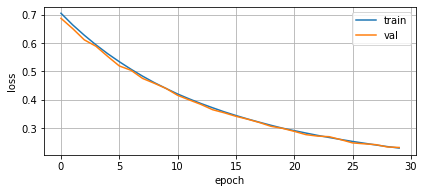

In [25]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_losses, label="train")
plt.plot(valid_losses,  label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.tight_layout()